# Comparing coordinate systems

In this example, we will study how the choice of coordinate system influences the behaviour of heyoka.py's adaptive integrator. We will focus on a simple (but nontrivial) dynamical system, consisting of a central Keplerian force field coupled to a force field constant in direction and magnitude. This dynamical system is known as the *Stark problem* or *accelerated Kepler problem*, and it has numerous applications of practical interest (including spaceflight mechanics, the dynamics of dust grains in the outer Solar System, atomic physics, etc.). Note that the Stark problem can be solved analytically via [elliptic functions](https://arxiv.org/abs/1306.6442), but of course here we will consider a numerical approach.

Without loss of generality, we can choose to orient the constant force field towards the positive $z$ direction. The Hamiltonian of the Stark problem in Cartesian coordinates (and adimensional units) thus reads:

$$
\mathcal{H}_\mathrm{cart}\left(v_x, v_y, v_z, x, y, z \right) = \frac{1}{2}\left( v_x^2+v_y^2+v_z^2 \right) - \frac{1}{\sqrt{x^2+y^2+z^2}} - \varepsilon z,
$$

where $\varepsilon$ is the magnitude of the constant acceleration field. For this study, we will pick a "small" value $\varepsilon=10^{-3}$, so that the constant acceleration field act as a perturbation on the otherwise Keplerian motion of the test particle:

In [1]:
# Value of the constant acceleration field.
eps = 1e-3

We will also select a set of initial conditions corresponding to a low-eccentricity, low-inclination orbit with semi-major axis $\sim 1$:

In [2]:
# Initial Cartesian conditions.
cart_ic = [0.48631041721670787, 0.6097331894913622, 0.05026407424597293,
           -0.917207331153677, 0.8411848961939183, 0.10100071061790256]

We will now proceed to integrate this dynamical system using several coordinate systems.

## Cartesian coordinates

We begin, as usual, with the creation of the symbolic Cartesian variables:

In [3]:
import heyoka as hy
vx, vy, vz, x, y, z = hy.make_vars("vx", "vy", "vz", "x", "y", "z")

Next, we build the Hamiltonian:

In [4]:
Ham_cart = 0.5 * (vx**2 + vy**2 + vz**2) - (x**2+y**2+z**2)**(-0.5) - eps*z
Ham_cart

(((0.50000000000000000 * ((square(vx) + square(vy)) + square(vz))) - pow(((square(x) + square(y)) + square(z)), -0.50000000000000000)) - (0.0010000000000000000 * z))

We are now ready to construct the adaptive integrator. In order to implement the equations of motion, we will use heyoka.py's expression system to symbolically differentiate the Hamiltonian:

In [5]:
# Construct the integrator object.
ta_cart = hy.taylor_adaptive(
    # Hamilton's equations.
    [(vx, -hy.diff(Ham_cart, x)),
     (vy, -hy.diff(Ham_cart, y)),
     (vz, -hy.diff(Ham_cart, z)),
     (x, hy.diff(Ham_cart, vx)),
     (y, hy.diff(Ham_cart, vy)),
     (z, hy.diff(Ham_cart, vz))],
    # Initial conditions.
    cart_ic
)

Let us now integrate the dynamics for a few time units and plot the resulting trajectory:

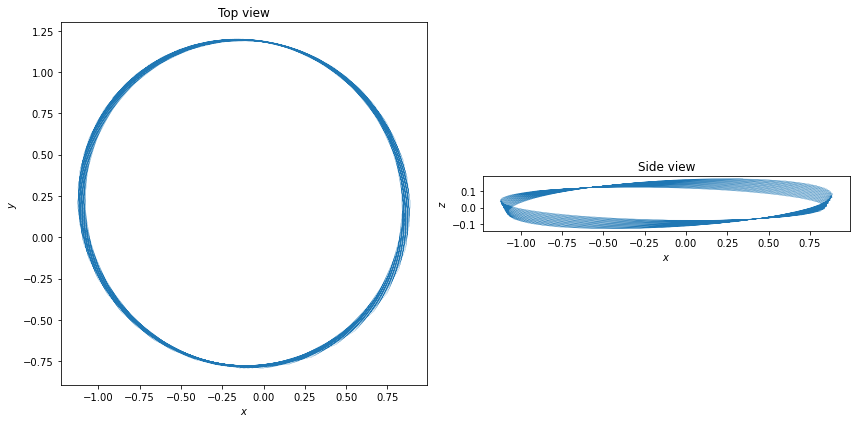

In [6]:
# Define a time grid for the integration.
import numpy as np
t_grid = np.linspace(0, 250, 1000)

# Integrate.
_, _, _, nsteps_cart, out_cart = ta_cart.propagate_grid(t_grid)

# Plot.
%matplotlib inline
from matplotlib.pylab import plt

fig = plt.figure(figsize = (12, 12))

ax1 = fig.add_subplot(1, 2, 1)
ax1.set_aspect('equal')
ax1.plot(out_cart[:, 3], out_cart[:, 4], linewidth=.2)
ax1.set_title("Top view")
ax1.set_xlabel("$x$")
ax1.set_ylabel("$y$")

ax2 = fig.add_subplot(1, 2, 2)
ax2.set_aspect('equal')
ax2.plot(out_cart[:, 3], out_cart[:, 5], linewidth=.2)
ax2.set_title("Side view")
ax2.set_xlabel("$x$")
ax2.set_ylabel("$z$")

plt.tight_layout();

The plot shows how the initially-Keplerian orbit is slowly being deformed by the constant acceleration field.

Let us also plot the time evolution of the Cartesian coordinates:

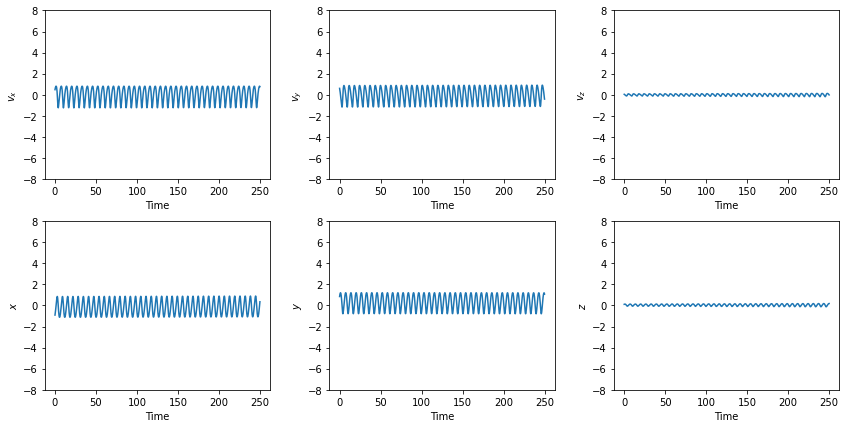

In [7]:
def plot_t_evol(out, labels):
    fig = plt.figure(figsize = (12, 6))
    
    max_abs = 8
    
    ncoord = out.shape[1]
    ncols = 3
    nrows = ncoord // ncols + (ncoord % ncols)

    for i in range(0, ncoord):
        ax = fig.add_subplot(nrows, ncols, i + 1)
        ax.plot(t_grid, out[:, i])
        ax.set_xlabel("Time")
        ax.set_ylabel(labels[i])
        ax.set_ylim(-max_abs, max_abs)
    
    plt.tight_layout()

plot_t_evol(out_cart, ["$v_x$", "$v_y$", "$v_z$", "$x$", "$y$", "$z$"])

Note that the oscillatory behaviour in these plots is a quasi-Keplerian motion driven by the central-force field. The additional constant acceleration has a longer-term secular effect which is however not immediately recognisable in these plots.

## Spherical coordinates

Let us now switch to a [spherical coordinate system](https://en.wikipedia.org/wiki/Spherical_coordinate_system). Because we are operating in the Hamiltonian framework, we cannot use directly the time derivatives $\left( \dot{r}, \dot{\theta}, \dot{\phi} \right)$ of the spherical coordinates as new momenta, and we have to use instead a set of canonical momenta $\left( p_r, p_\theta, p_\phi \right)$. The coordinate transformation $\left(v_x, v_y, v_z, x, y, z\right) \rightarrow \left( p_r, p_\theta, p_\phi, r, \theta, \phi \right)$ reads:

$$
\begin{aligned}
p_r & = \dot{r}, & r & =  \sqrt{x^2+y^2+z^2}, \\
p_\theta & = r^2\dot{\theta}, & \theta & = \arccos \frac{z}{r}, \\
p_\phi & = r^2\dot{\phi}\sin^2\theta, & \phi & = \arctan \frac{y}{x}.
\end{aligned}
$$

The Hamiltonian of the Stark problem in spherical coordinates becomes:

$$
\mathcal{H}_\mathrm{sph} = \frac{1}{2}\left( p_r^2+\frac{p_\theta^2}{r^2} + \frac{p_\phi^2}{r^2\sin^2\theta} \right) - \frac{1}{r} - \varepsilon r \cos\theta.
$$

Let us define a couple of functions to convert a state vector between Cartesian and spherical coordinates:

In [8]:
# Cartesian to spherical.
def cart2sph(state):
    from numpy import sqrt, arccos, arctan2
    vx,vy,vz,x,y,z = state
    r = sqrt(x**2+y**2+z**2)
    th = arccos(z/r)
    phi = arctan2(y,x)
    vr = (vx*x+vy*y+vz*z)/r
    vth = (z*vr-vz*r)/(r**2*sqrt(1-z**2/r**2))
    vphi = (vy*x-vx*y)/(x**2+y**2)
    return vr,vth,vphi,r,th,phi

# Spherical to Cartesian.
def sph2cart(state):
    from numpy import sin, cos
    vr,vth,vphi,r,th,phi = state
    x = r*sin(th)*cos(phi)
    y = r*sin(th)*sin(phi)
    z = r*cos(th)
    vx = vr*sin(th)*cos(phi)+r*(vth*cos(th)*cos(phi)-vphi*sin(th)*sin(phi))
    vy = vr*sin(th)*sin(phi)+r*(vth*cos(th)*sin(phi)+vphi*sin(th)*cos(phi))
    vz = vr*cos(th)-r*vth*sin(th)
    return vx,vy,vz,x,y,z

# Spherical to Hamiltonian spherical.
def sph2spham(state):
    from numpy import sin
    vr,vth,vphi,r,th,phi = state
    return vr,r**2*vth,r**2*vphi*sin(th)**2,r,th,phi

# Hamiltonian spherical to spherical.
def spham2sph(state):
    from numpy import sin
    pr,pth,pphi,r,th,phi = state
    return pr,pth/r**2,pphi/(r**2*sin(th)**2),r,th,phi

We are now almost ready to numerically integrate the Stark problem in spherical coordinates. There is one additional complication however that we need to take into account.

Because now we are operating in spherical coordinates, two of the coordinates are angles $\left(\theta, \phi \right)$ whose numerical values can grow in principle unbounded even if the motion remains bounded. In this specific example, the angle $\phi$ will keep on growing as the particle orbits around the origin.

This constant growth can become a problem because heyoka.py uses the largest absolute value in the state vector to transform the relative integration tolerance into an absolute error allowed within the integration loop: in other words, if (the absolute value of) $\phi$ keeps on growing, the integrator will progressively become less accurate.

We can avoid this undesirable effect by periodically reducing $\phi$ modulo $2\pi$. One possible way of implementing this is to define a callback function to be called at the end of every integration timestep:

In [9]:
def mod_cb_sph(ta):
    # Fetch the current value of phi
    # from the state vector.
    phi = ta.state[5]
    
    # If phi is outside the [-pi, pi] range,
    # bring it back to [-pi, pi].
    if phi < -np.pi or phi > np.pi:
        ta.state[5] = (phi + np.pi) % (2 * np.pi) - np.pi
    
    return True

We can now proceed to the numerical integration:

In [10]:
# Create the spherical symbolic variables.
pr, pth, pphi, r, th, phi = hy.make_vars("pr", "pth", "pphi", "r", "th", "phi")

# Define the Hamiltonian in spherical coordinates.
Ham_sph = 0.5 * (pr**2+(pth/r)**2+(pphi/(r*hy.sin(th)))**2) - 1./r - eps*r*hy.cos(th)

# Convert the initial Cartesian conditions.
sph_ic = sph2spham(cart2sph(cart_ic))

# Create the integrator object.
ta_sph = hy.taylor_adaptive(
    [(pr, -hy.diff(Ham_sph, r)),
     (pth, -hy.diff(Ham_sph, th)),
     (pphi, -hy.diff(Ham_sph, phi)),
     (r, hy.diff(Ham_sph, pr)),
     (th, hy.diff(Ham_sph, pth)),
     (phi, hy.diff(Ham_sph, pphi))],
    sph_ic
)

# Run the integration.
_, _, _, nsteps_sph, out_sph = ta_sph.propagate_grid(t_grid,
                                                     # Callback to reduce the
                                                     # value of phi to [-pi, pi].
                                                     callback = mod_cb_sph)

Let's take a look at the results:

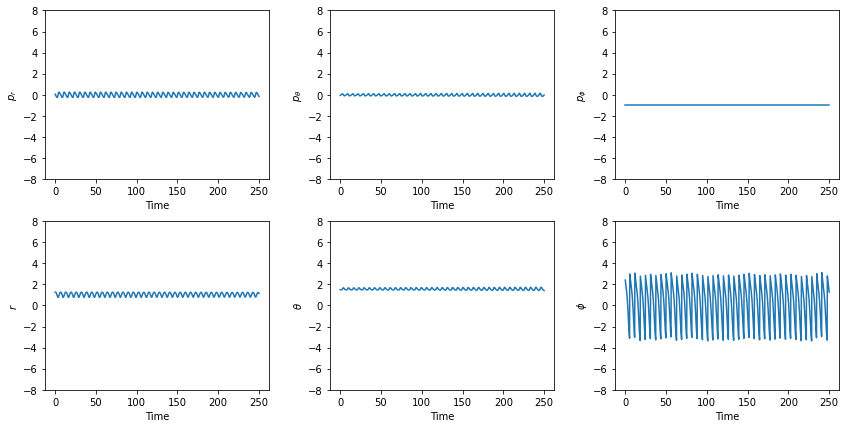

In [11]:
plot_t_evol(out_sph, ["$p_r$", r"$p_\theta$", r"$p_\phi$", "$r$", r"$\theta$", r"$\phi$"])

Comparing these plots with those for the Cartesian coordinates, we can see how the oscillatory quasi-Keplerian behaviour remains. However, the oscillation amplitude is reduced with respect to the Cartesian case, and one of the momenta ($p_\phi$, top right panel) has become a constant. This reflects the fact that the $z$ component of the angular momentum in the Stark problem is a constant of motion.

Note that the bottom right panel, referring to the time evolution of $\phi$, does **not** represent an oscillatory motion around 0: the sine-like shape is a visual effect of the periodic reduction of $\phi$ to the $\left[ -\pi, \pi\right]$ range, but in reality the time evolution of $\phi$ is linear with a periodic modulation on top.

The periodic modulations in these plots arise from the fact that the initial Keplerian orbit is not perfectly circular and planar, and thus all coordinates (except $p_\phi$) oscillate as the motion deviates from a perfect planar circle within each orbit. For a circular planar orbit around the origin, all coordinates and momenta would be constants, except for $\phi$ which would evolve linearly.

The fact that the amplitude of the periodic modulations is reduced with respect to the Cartesian case has an effect on the number of timesteps necessary to integrate the system:

In [12]:
print("Number of steps (Cartesian): {}".format(nsteps_cart))
print("Number of steps (spherical): {}".format(nsteps_sph))

Number of steps (Cartesian): 1002
Number of steps (spherical): 899


The reduction is not dramatic, but nevertheless measurable.

Spherical coordinates require fewer timesteps because the reduction in the amplitude of the oscillatory motions improves the convergence of the Taylor series that heyoka.py uses internally to propagate the motion at each timestep. In other words, when using spherical coordinates the Taylor series synthesised by heyoka.py at each timestep can describe accurately the solution of the system for longer intervals of time.

## Delaunay elements

The results of the previous section suggest that introducing another system of coordinates which further reduces the amplitude of periodic oscillations may further decrease the number of timesteps required by the integrator. Because we are dealing with a perturbed Keplerian system, an obvious choice is to use [Keplerian orbital elements](https://en.wikipedia.org/wiki/Orbital_elements).

In the Hamiltonian formalism, we cannot use directly the Keplerian elements as coordinates as they are not canonical variables. Instead, we can use the [Delaunay elements](https://en.wikipedia.org/wiki/Orbital_elements#Delaunay_variables), which are closely-related to the Keplerian elements via the following relations (valid in adimensional units):

$$
\begin{aligned}
L & = \sqrt{a}, & l & =  M, \\
G & = \sqrt{a\left( 1 - e^2\right)}, & g & = \omega, \\
H & = \sqrt{a\left( 1 - e^2\right)} \cos i, & h & =  \Omega.
\end{aligned}
$$

In these formulae, $\left( a, e, i, M, \omega, \Omega \right)$ are the usual Keplerian elements: semi-major axis, eccentricity, inclination, mean anomaly, longitude of pericentre and longitude of the ascending node.

When employing Delaunay elements, a major complication is the appearance of the mean anomaly $l$, which is related to the eccentric anomaly $E$ via [Kepler's equation](https://en.wikipedia.org/wiki/Kepler%27s_equation), which, in terms of Delaunay elements, reads:

$$
l = E - \sqrt{1-\frac{G^2}{L^2}} \sin E.
$$

This equation cannot be inverted in finite terms using elementary functions, thus, from now on, we will regard the eccentric anomaly $E$ as an unspecified function of $l$, $G$ and $L$:

$$
E = E\left( l, G, L \right).
$$

The cartesian coordinate $z$ can be written in terms of Delaunay elements as

$$
z = L\sqrt{1-\frac{H^2}{G^2}}\left[ L\left( \cos E - \sqrt{1-\frac{G^2}{L^2}} \right)\sin g + G\sin E \cos g \right],
$$

while the two-body problem Hamiltonian is simply

$$
\mathcal{H}_\mathrm{2bp} = -\frac{1}{2L^2}.
$$

Thus, the full Hamiltonian for the Stark problem in Delaunay elements reads:

$$
\mathcal{H}_\mathrm{Del} \left( L, G, H, l, g, h \right) = -\frac{1}{2L^2}-\varepsilon L\sqrt{1-\frac{H^2}{G^2}}\left[ L\left( \cos E - \sqrt{1-\frac{G^2}{L^2}} \right)\sin g + G\sin E \cos g \right].
$$

In order to write the equations of motion, we will have to take into account that $E$ is a function of $\left( l, G, L \right)$ whose derivatives can be explicitly computed from Kepler's equation:

$$
\begin{aligned}
\frac{\partial E}{\partial l} & = \frac{1}{1-\sqrt{1-\frac{G^2}{L^2}}\cos E},\\
\frac{\partial E}{\partial L} & = \frac{G^2\sin E}{L^3\sqrt{1-\frac{G^2}{L^2}}\left(1-\sqrt{1-\frac{G^2}{L^2}}\cos E\right)},\\
\frac{\partial E}{\partial G} & = \frac{-G\sin E}{L^2\sqrt{1-\frac{G^2}{L^2}}\left(1-\sqrt{1-\frac{G^2}{L^2}}\cos E\right)}.
\end{aligned}
$$

We can now proceed to formulate the equations of motion:

$$
\begin{aligned}
\frac{dL}{dt} & =-\frac{\partial \mathcal{H}_\mathrm{Del}}{\partial E}\frac{\partial E}{\partial l}, & \frac{dl}{dt} & =  \frac{\partial \mathcal{H}_\mathrm{Del}}{\partial L}+\frac{\partial \mathcal{H}_\mathrm{Del}}{\partial E}\frac{\partial E}{\partial L}, \\
\frac{dG}{dt} & = -\frac{\partial \mathcal{H}_\mathrm{Del}}{\partial g}, & \frac{dg}{dt} & = \frac{\partial \mathcal{H}_\mathrm{Del}}{\partial G}+\frac{\partial \mathcal{H}_\mathrm{Del}}{\partial E}\frac{\partial E}{\partial G}, \\
\frac{dH}{dt} & = -\frac{\partial \mathcal{H}_\mathrm{Del}}{\partial h}=0, & \frac{dh}{dt} & =  \frac{\partial \mathcal{H}_\mathrm{Del}}{\partial H} .
\end{aligned}
$$

Note that the Hamiltonian does not depend directly on $l$ (only indirectly via $E$). Thus, in the numerical integration, we will be replacing the differential equation for $l$ with the differential equation for $E$:

$$
\frac{dE}{dt}=\frac{\partial E}{\partial l}\frac{dl}{dt}+\frac{\partial E}{\partial L}\frac{dL}{dt} + \frac{\partial E}{\partial G}\frac{dG}{dt}.
$$

The value of $l$ for a given $E$ can be obtained via Kepler's equation.

On the implementation side, let us begin with a couple of functions to convert between Cartesian coordinates and Delaunay elements. We will be using [pykep](https://esa.github.io/pykep/) for the conversion between cartesian coordinates and Keplerian elements:

In [13]:
# Cartesian to Delaunay.
def cart2del(state):
    import pykep as pk
    
    vx,vy,vz,x,y,z = state

    a,e,i,Om,om,E = pk.ic2par([x, y, z], [vx, vy, vz])
    
    L = np.sqrt(a)
    G = np.sqrt(a*(1-e**2))
    H = G*np.cos(i)
    
    g = om
    h = Om
    
    return [L, G, H, E, g, h]

# Delaunay to cartesian.
def del2cart(state):
    import pykep as pk
    
    L,G,H,E,g,h = state
    
    a = L**2
    e = np.sqrt(1-G**2/L**2)
    i = np.arccos(H/G)
    
    Om = h
    om = g
    
    ret = pk.par2ic([a, e, i, Om, om, E])
   
    return [ret[1][0], ret[1][1], ret[1][2], ret[0][0], ret[0][1], ret[0][2]]

Next, we formulate the Hamiltonian and the equations of motion:

In [14]:
# Symbolic variables for the Delaunay elements.
L, G, H, E, g, h = hy.make_vars("L", "G", "H", "E", "g", "h")

# The Hamiltonian.
Ham_del = -0.5*L**-2 - eps*L*hy.sqrt(1.-H**2*G**-2)*(L*(hy.cos(E)-hy.sqrt(1.-G**2*L**-2))*hy.sin(g)+G*hy.sin(E)*hy.cos(g))

# Derivatives of E wrt l, L and G.
dE_dl = (1. - hy.sqrt(1.-G**2*L**-2)*hy.cos(E))**-1
dE_dL = G**2*hy.sin(E)/(L**3*hy.sqrt(1.-G**2*L**-2)*(1. - hy.sqrt(1.-G**2*L**-2)*hy.cos(E)))
dE_dG = -G*hy.sin(E)/(L**2*hy.sqrt(1.-G**2*L**-2)*(1. - hy.sqrt(1.-G**2*L**-2)*hy.cos(E)))

# Equations of motion.
dL_dt = -hy.diff(Ham_del, E) * dE_dl
dG_dt = -hy.diff(Ham_del, g)
dH_dt = hy.expression(0.)
dl_dt = hy.diff(Ham_del, L) + hy.diff(Ham_del, E) * dE_dL
dg_dt = hy.diff(Ham_del, G) + hy.diff(Ham_del, E) * dE_dG
dh_dt = hy.diff(Ham_del, H)
dE_dt = dE_dl * dl_dt + dE_dL * dL_dt + dE_dG * dG_dt

Like in the case of spherical coordinates, we will also need to prevent $E$ from growing indefinitely:

In [15]:
# Callback to reduce E to the
# [-pi, pi] range.
def mod_cb_del(ta):
    E = ta.state[3]
    if E < -np.pi or E > np.pi:
        ta.state[3] = (E + np.pi) % (2 * np.pi) - np.pi
    
    return True

We are now ready to create the integrator object:

In [16]:
# Convert the initial conditions
# into Delaunay elements.
del_ic = cart2del(cart_ic)

# Create the integrator.
ta_del = hy.taylor_adaptive(
    [(L, dL_dt),
     (G, dG_dt),
     (H, dH_dt),
     (E, dE_dt),
     (g, dg_dt),
     (h, dh_dt)],
    del_ic
)

Let us proceed to the numerical integration:

In [17]:
_, _, _, nsteps_del, out_del = ta_del.propagate_grid(t_grid, callback = mod_cb_del)

We can now take a look at the time evolution of the orbital elements:

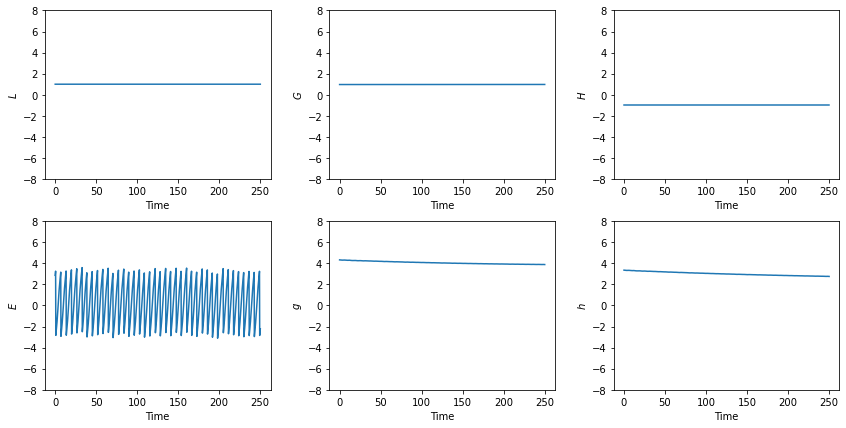

In [18]:
plot_t_evol(out_del, ["$L$", "$G$", "$H$", "$E$", "$g$", "$h$"])

The plots for $L$, $G$, $H$, $g$ and $h$ clearly show how the Keplerian oscillations for these elements have been removed thanks to the use of orbital elements as a coordinate system. These elements would be constant in a perfectly Keplerian orbit, while in the Stark problem they undergo short-term oscillations with amplitude $\sim\varepsilon$ and long-term evolution with timescale $\sim 1/\varepsilon$. We can see the perturbation induced by the constant acceleration field by zooming into, e.g., the plot for the $g$ angle (the argument of pericentre):

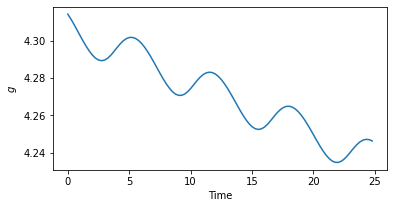

In [19]:
fig = plt.figure(figsize = (6, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(t_grid[:100], out_del[:100, 4])
ax.set_xlabel("Time")
ax.set_ylabel("$g$");

Let us now zoom into the plot for $E$:

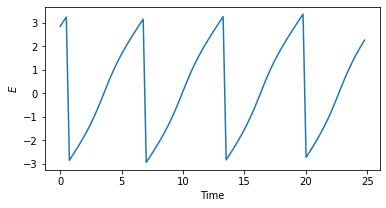

In [20]:
fig = plt.figure(figsize = (6, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(t_grid[:100], out_del[:100, 3])
ax.set_xlabel("Time")
ax.set_ylabel("$E$");

We can see how $E$ is still subject to Keplerian oscillations. Indeed, even in a perfectly Keplerian orbit, the time evolution of $E$ is linear only for circular orbits.

Because of the presence of Keplerian oscillations in $E$, the reduction in number of integration timesteps after switching to Delaunay elements is measurable but not very large:

In [21]:
print("Number of steps (Cartesian): {}".format(nsteps_cart))
print("Number of steps (spherical): {}".format(nsteps_sph))
print("Number of steps (Delaunay) : {}".format(nsteps_del))

Number of steps (Cartesian): 1002
Number of steps (spherical): 899
Number of steps (Delaunay) : 764


In order to further reduce the number of timesteps, we will have to implement one final trick.

## Delaunay + Sundman

The idea we will be exploring in this section is to replace the time $t$ with a fictitious time $\tau$ defined by the differential relation

$$
\frac{dt}{d\tau} = r,
$$

where $r$ is the distance from the Keplerian centre of force (i.e., the origin). This time transformation belongs to the class of [Sundman transformations](https://en.wikipedia.org/wiki/Karl_F._Sundman), which were originally introduced for regularisation purposes: the fictitious time $\tau$ flows slower close to the centre of force, so that it is impossible for a test particle to reach the gravitational singularity as that would take an infinite amount of fictitious time $\tau$.

Here, however, we are not interested in the regularisation properties of this transformation. Rather, what is of interest to us in this context is that, in Keplerian orbits, $E$ evolves *linearly* with $\tau$. In other words, by replacing the time coordinate $t$ with $\tau$, we will be able to remove the Keplerian oscillations of $E$ in the Stark problem.

We can introduce the new time coordinate $\tau$ directly in the definition of the equations of motion. $r$ can be expressed in terms of Delaunay elements as

$$
r = L^2\left( 1 - \sqrt{1-\frac{G^2}{L^2}}\cos E\right).
$$

For each Delaunay element $D_i$ we can then write:

$$
\frac{dD_i}{d\tau} = \frac{dD_i}{dt}\frac{dt}{d\tau} = \frac{dD_i}{dt} L^2\left( 1 - \sqrt{1-\frac{G^2}{L^2}}\cos E\right).
$$

We will also append the differential equation for $dt/d\tau$ to the ODE system, so that we can track the evolution of the real time $t$ in fictitious time $\tau$:

In [22]:
# Expression for dt/dtau.
dt_dtau = L**2*(1 - hy.sqrt(1.-G**2*L**-2) * hy.cos(E))

# Additional dynamical variable to
# integrate t(tau).
t, = hy.make_vars("t")

ta_del_e = hy.taylor_adaptive(
    [(L, dL_dt*dt_dtau),
     (G, dG_dt*dt_dtau),
     (H, dH_dt*dt_dtau),
     (E, dE_dt*dt_dtau),
     (g, dg_dt*dt_dtau),
     (h, dh_dt*dt_dtau),
     (t, dt_dtau)
    ],
    # Both t and tau
    # start at zero.
    del_ic + [0.]
)

In order to prevent the real time $t$ from growing indefinitely, we will periodically reset its value:

In [23]:
def mod_cb_del_e(ta):
    # Reduce E to the [-pi, pi] range.
    E = ta.state[3]
    if E < -np.pi or E > np.pi:
        ta.state[3] = (E + np.pi) % (2 * np.pi) - np.pi

    # Modulo reduction of t when it
    # grows past 5.
    t = ta.state[6]
    if t > 5:
        ta.state[6] = t % 5
    
    return True

We can now proceed to the integration:

In [24]:
_, _, _, nsteps_del_e, out_del_e = ta_del_e.propagate_grid(t_grid, callback = mod_cb_del_e)

Let us plot the results:

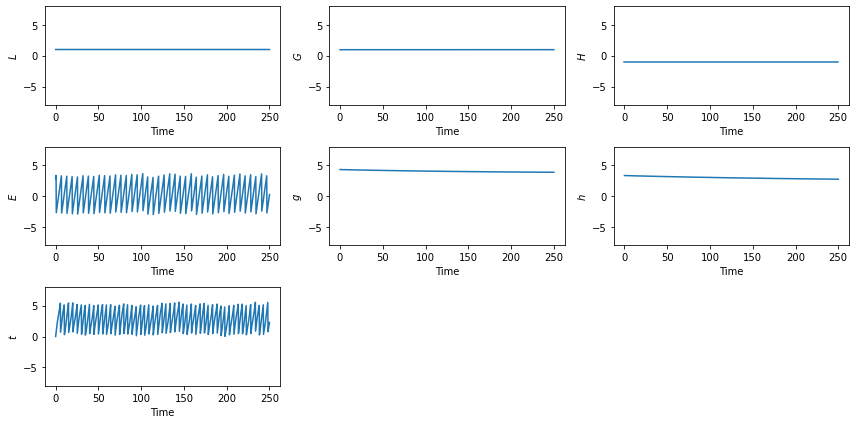

In [25]:
plot_t_evol(out_del_e, ["$L$", "$G$", "$H$", "$E$", "$g$", "$h$", "$t$"])

And let us zoom into the plot for $E$:

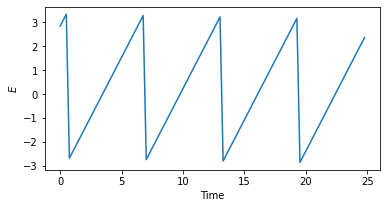

In [26]:
fig = plt.figure(figsize = (6, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(t_grid[:100], out_del_e[:100, 3])
ax.set_xlabel("Time")
ax.set_ylabel("$E$");

The plot indeed confirms that the Keplerian oscillations for $E$ are gone.

What about the number of steps?

In [27]:
print("Number of steps (Cartesian): {}".format(nsteps_cart))
print("Number of steps (spherical): {}".format(nsteps_sph))
print("Number of steps (Delaunay) : {}".format(nsteps_del))
print("Number of steps (D + S)    : {}".format(nsteps_del_e))

Number of steps (Cartesian): 1002
Number of steps (spherical): 899
Number of steps (Delaunay) : 764
Number of steps (D + S)    : 388


We can see how, after the removal of the short-term Keplerian oscillations from $E$, the reduction in number of steps is substantial. Indeed, in the Delaunay + Sundman setup, the evolution of the coordinates in fictitious time deviates from constant or linear behaviour only through the external perturbation, whose magnitude $\varepsilon$ is small.

Let us conclude by summarising in a plot the number of steps required by each coordinate system:

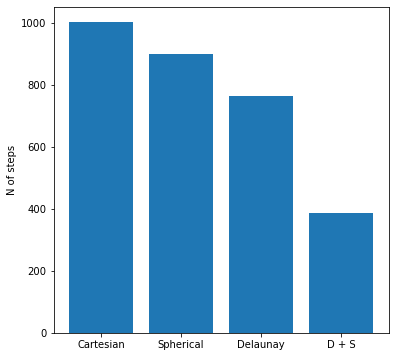

In [28]:
fig = plt.figure(figsize = (6, 6))
ax = fig.add_subplot(1, 1, 1)
ax.bar(range(4), [nsteps_cart, nsteps_sph, nsteps_del, nsteps_del_e], tick_label=["Cartesian", "Spherical", "Delaunay", "D + S"])
ax.set_ylabel("N of steps");

## Conclusions

In this example we have shown how the choice of coordinate system and time coordinate can influence the behaviour of a Taylor integrator. Intuitively, the closer the time evolution of a coordinate is to a polynomial, the longer the Taylor series can approximate the ODE solution, and the fewer number of steps is required.

In these experiments we focused only on the number of steps as a performance metric. Clearly, the use of more sophisticated coordinate systems (such as the Delaunay elements) can lead to more complicated equations of motion, which in turn may lead to overall longer integration times. Nevertheless, the minimisation of the number of timestpes may be of interest in some cases (e.g., to reduce the accumulation of numerical errors in long-term integrations).